In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

dataset = load_diabetes()
print(dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [7]:
# Save the input and target variables
print(dataset.keys())
data = dataset['data']
targets = dataset['target']

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [10]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0)) / targets.std()

In [14]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)
print("Data shape: ", data.shape)
print("Train Data shape: ", train_data.shape)
print("Train target Shape: ", train_targets.shape)

Data shape:  (442, 10)
Train Data shape:  (397, 10)
Train target Shape:  (397,)


#### Train a feedforward neural network model

In [21]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ]
    )
    return model
model = get_model()

In [22]:
# Print the model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 51,073
Trainable params: 51,073
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [24]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [25]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=False)


[0.8760153975751664, 0.66744477]

#### Plot the learning curves

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

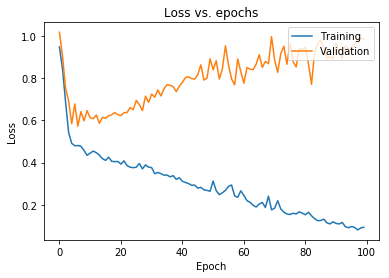

In [27]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [31]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [32]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],),kernel_regularizer=regularizers.l2(wd)
             )
        ,
        Dropout(rate),
        Dense(128, activation="relu",
              kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu",
              kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu",
              kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu",
              kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu",
              kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [33]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)


In [34]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, verbose=False, batch_size=64)


In [37]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets)

45/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.46115109390682646, 0.52316636]

#### Plot the learning curves

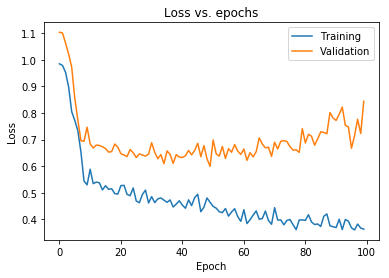

In [38]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [39]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training...")
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Starting batch {batch}")
    def on_train_batch_end(self, batch, logs=None):
        print(f"Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
    def on_train_end(self, logs=None):
        print(f"Finished training.")


In [41]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)


In [42]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [44]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, validation_split=0.15, batch_size=64, verbose=False, epochs=3, callbacks=[CustomCallback()])


Starting training...
Starting epoch 0
Starting batch 0
Finished batch 0
Starting batch 1
Finished batch 1
Starting batch 2
Finished batch 2
Starting batch 3
Finished batch 3
Starting batch 4
Finished batch 4
Starting batch 5
Finished batch 5
Finished epoch 0
Starting epoch 1
Starting batch 0
Finished batch 0
Starting batch 1
Finished batch 1
Starting batch 2
Finished batch 2
Starting batch 3
Finished batch 3
Starting batch 4
Finished batch 4
Starting batch 5
Finished batch 5
Finished epoch 1
Starting epoch 2
Starting batch 0
Finished batch 0
Starting batch 1
Finished batch 1
Starting batch 2
Finished batch 2
Starting batch 3
Finished batch 3
Starting batch 4
Finished batch 4
Starting batch 5
Finished batch 5
Finished epoch 2
Finished training.


In [45]:
# Evaluate the model
model.evaluate(test_data, test_targets)


45/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.9980860816107856

In [ ]:
# Make predictions with the model



***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [70]:
# Re-train the unregularised model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, mode='min', min_delta=0.01)
# early_stopping=EarlyStopping()
unregularized_model = get_model()
unregularized_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularized_model.fit(train_data, train_targets, epochs=100, verbose=False, callbacks=[early_stopping], validation_split=0.15)


In [71]:
unregularized_model.evaluate(test_data, test_targets)

45/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.45446988741556804

In [72]:
# Re-train the regularised model

regularized_model = get_regularised_model(1e-5, 0.3)
regularized_model.compile(optimizer='adam', loss='mse')
reg_history= regularized_model.fit(train_data, train_targets, epochs=100, verbose=False, callbacks=[early_stopping], validation_split=0.15)

In [73]:
# Evaluate the model on the test set
regularized_model.evaluate(test_data, test_targets)


45/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.5010704093509251

#### Plot the learning curves

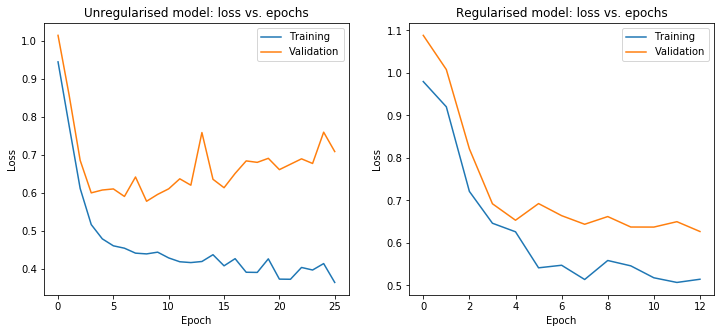

In [74]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()